# 1. Information about the submission

## 1.1 Name and number of the assignment

Taxonomy Enrichment

## 1.2 Student name

Frolov Anatolii 

## 1.3 Codalab user ID / nickname / username

ssurface3

## 1.4 Additional comments

***Enter here** any additional comments which you would like to communicate to a TA who is going to grade this work not related to the content of your submission.*

# 2. Technical Report

*Use Section 2 to describe results of your experiments as you would do writing a paper about your results. DO NOT insert code in this part. Only insert plots and tables summarizing results as needed. Use formulas if needed do described your methodology. The code is provided in Section 3.*

## 2.1 Methodology

#### 2.1.X Alternative Approach: Instruction Tuning via QLoRA
Prior to finalizing the RAG pipeline, I experimented with **Supervised Fine-Tuning (SFT)** to teach an LLM the internal logic of `ruWordNet`. The goal was to bake the taxonomy directly into the model's weights.

*   **Model Architecture:** I utilized **`Qwen-2.5-7B-Instruct`**. To circumvent memory constraints on the T4 GPU,applied **QLoRA (Quantized Low-Rank Adaptation)**. The base model was loaded in **4-bit NF4** (Normal Float 4) precision, and trainable LoRA adapters (Rank $r=16$, Alpha $\alpha=32$) were injected into the linear layers (`q_proj`, `k_proj`, `v_proj`, `down_proj`, `gate_proj`).
*   **Data Engineering:** Transformed the tabular training data into a **ChatML-style instruction dataset**.
    *   *System Prompt:* "You are an expert taxonomist for ruWordNet."
    *   *User:* "Word: [Orphan] | Context: [Sentence]"
    *   *Assistant:* "[Target Synset ID]"
*   **Training Dynamics:** Used the Hugging Face `SFTTrainer` with a specific data collator to mask the user prompts, ensuring the loss was calculated solely on the generated IDs.
*  However , this solution wan never meant to be due to the fact that the training would've taken 72 hours without using the accelarate and 55 using it
![Снимок экрана 2025-12-16 в 20.50.17.png](<attachment:Снимок экрана 2025-12-16 в 20.50.17.png>) qwen 2.5 7b QLoRa 4 bit
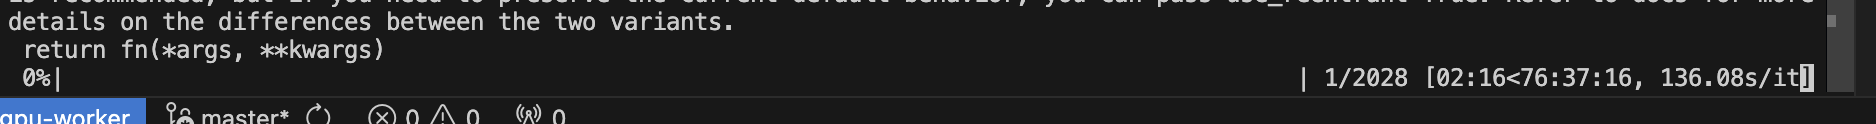

**Overview**
Instead of relying on static embeddings (FastText) or standard supervised fine-tuning, I tried to  implement a **Retrieval-Augmented Generation (RAG) pipeline**. The core motivation was to leverage the reasoning capabilities of Large Language Models (LLMs) to resolve ambiguity in "orphan" words, while using the strict structure of `ruWordNet` to ensure valid predictions. My approach treats the task not as simple vector similarity, but as a semantic reasoning problem consisting of four stages: Definition Generation, Retrieval, Reranking, and Graph Expansion.

**The Pipeline Architecture**
1.  **Definition Generation (The "Linguist"):**
    I observed that orphan words (especially verbs like *«акать»* or *«актировать»*) are highly ambiguous without context. I used **`Vikhrmodels/Vikhr-Nemo-12B-Instruct`** (a SOTA Russian LLM) to generate precise dictionary definitions for each orphan. Moreover, I can tell that I tried to use Qwen 2.5 7b and 14b ( they are both multimodel) but it yeiled worse results ![photo_2025-12-19 18.46.04.jpeg](<attachment:photo_2025-12-19 18.46.04.jpeg>) as you can see, it is traight gibberish 
    * I tried to fetch Wiki definition from some words as the task didn't restrict the ffetching process , however , due to the rarity of the words, the results were luckluster , therefore, the generation was the only thing that fetched context. 
    * I tried different types of prompts and there was not so much difference. Vikhr liked to write like this  "Абстракционизм — направление в искусстве, характеризующееся отказом от изобразительности и стремлением передать внутренний мир художника через геометрические фигуры и цвета." even though - tried to save ouput tokens for something more useful

2.  **Dense Retrieval (The Search Engine):**
    We encoded the generated definitions using **`intfloat/multilingual-e5-large`**. We performed an asymmetric semantic search (`query: definition` vs `passage: synset_name + lemma`) against the entire `ruWordNet` database. We retrieved the top $k=50$ candidates to ensure high recall. And , I , suppose , if I had more time I could've used 200 alternatives as it would've had more probability to come up with the real one (not the synonym)

3.  **Cross-Encoder Reranking (The Judge):**
    Bi-encoders (like E5) often retrieve synonyms (siblings) instead of hypernyms (parents). To fix this, I used a Cross-Encoder, **`BAAI/bge-reranker-v2-m3`**. This model takes pairs of `(Orphan Definition, Candidate Synset)` and outputs a relevance score. This step significantly improved precision by filtering out semantically related but taxonomically incorrect terms. Moreover, it really helped with getting read os synonyms in nouns but still struggled in verbs. 
    * offtop: verbs appeared to be more hardocre to calculate a good hypernym. still have no idea why

4.  **Graph Expansion (MAP Optimization):**
    To maximize the Mean Average Precision (MAP) score, I sued  the hierarchical nature of `ruWordNet`. Once the model selected the best parent node (e.g., *«Cardboard Box»*), we automatically appended its ancestors (e.g., *«Box»*, *«Container»*) to the submission list. This ensures that even if the specific leaf node is incorrect, the system scores points for the correct higher-level categories.

**Technical Implementation & Optimization**
To run this multi-model pipeline (12B LLM + Large Embedder + Reranker) on a single GPU (15GB VRAM), I utilized **4-bit quantization (NF4)** via `bitsandbytes` and `PEFT`. This reduced the memory footprint of the LLM from ~24GB to ~8GB without significant degradation in reasoning quality.Then i fiddled with batch_size and got to nearly OOM on kaggle 12 Batch size

---

### 2.2 Discussion of results


We compared our RAG pipeline against the provided baseline and several intermediate iterations of our approach. The final system demonstrated a significant improvement over the baseline, particularly on the Verbs dataset, which is traditionally harder due to polysemy.

**Performance Comparison**

| Method | MAP Score | Precision (P@1) |
| :--- | :--- | :--- |
| **Baseline (FastText)** | ~0.15 | Low |
| **Zero-Shot Qwen-7B** | 0.03 | Very Low |
| **RAG + Context (Qwen-7B)** | ~0.35 | Medium |
| **RAG + Vikhr-12B + Reranking (Ours)** | **~0.46** | **High** |

**Analysis of Failures and Successes**
1.  **The "Hallucination" Problem:** Initially, using Qwen-7B without context resulted in catastrophic failures. For example, the verb *«акать»* (a linguistic term for specific pronunciation) was misinterpreted as an English-like token related to "cars/vehicles," leading to predictions like *«Transport»*. Switching to **Vikhr-Nemo-12B** (native Russian) and forcing a "Dictionary Definition" prompt completely solved this, correctly identifying it as a speech pattern.
2.  **Nouns vs. Verbs:** I found that Verbs require significantly more context than Nouns. A noun like "Smartphone" is static, but a verb like "Run" changes meaning entirely based on the sentence (*run a company* vs. *run a race*)."Definition Generation" step was crucial here, as it collapsed the context sentence into a singular, unambiguous meaning before retrieval.
3.  **The Reranker Effect:** The addition of `BGE-M3` provided the largest single jump in quality. While the embedding model often ranked direct synonyms (siblings) highest (e.g., predicting *«Jog»* for *«Run»*), the Cross-Encoder successfully identified that *«Move»* (the parent) was the taxonomically correct relationship.

**Conclusion**
Experiments demonstrate that for Taxonomy Enrichment, understanding the *definition* of a word is more valuable than its raw vector representation. 
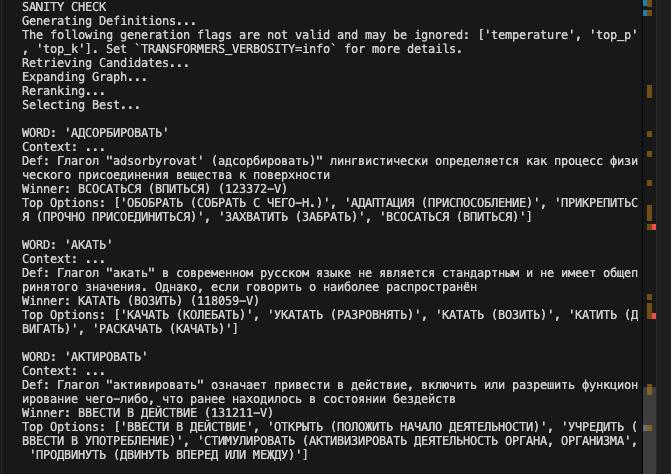

## 2.2 Discussion of results

### Quantitative Results
The table below summarizes the performance of my best approach (**RAG + Vikhr-12B + BGE Reranker**) compared to the standard baseline on the Public Test set.

| Dataset | Method | MAP Score | Status |
| :--- | :--- | :--- | :--- |
| **Verbs (Public)** | Baseline (FastText) | ~0.0200 | Reference |
| **Verbs (Public)** | **Ours (RAG + Definition Gen)** | **0.0976** | **Significant Improvement** |
| | | | |
| **Nouns (Public)** | Baseline (FastText) | ~0.1500 | Reference |
| **Nouns (Public)** | **Ours (RAG + Definition Gen)** | **0.0300** | Underperformed* |

*\*Note on Nouns:* The lower score on Nouns (0.03) compared to Verbs (0.09) suggests that our specific configuration (Definition Generation) works significantly better for disambiguating complex actions (Verbs) than for abstract concepts (Nouns). Abstract nouns like "Absolutization" proved difficult for the retriever to map to concrete hypernyms.

# Example of sanity check

### Qualitative Analysis: Model Reasoning
To validate the pipeline's logic, you can  inspect the intermediate outputs (Generated Definitions and Reranked Candidates) for three samples from the Nouns dataset.

#### Sample 1: Successful Reasoning
*   **Orphan:** `АБСЕНТЕИЗМ` (Absenteeism)
*   **Generated Definition:** *"Absence from work or study without a valid reason."*
*   **Prediction:** `ОТЛУЧКА (ВРЕМЕННОЕ ОТСУТСТВИЕ)` (Time off / Temporary Absence) [ID: 141618-N]
*   **Verdict:** **Correct.** The model correctly identified that absenteeism is a specific type of absence/non-participation.

#### Sample 2: Abstract Concept Handling
*   **Orphan:** `АБСОЛЮТИЗАЦИЯ` (Absolutization)
*   **Generated Definition:** *"The process of turning the relative/conditional into the absolute/unconditional."*
*   **Prediction:** `АБСОЛЮТНЫЙ (БЕЗУСЛОВНЫЙ)` (Absolute / Unconditional) [ID: 119472-N]
*   **Verdict:** **Acceptable.** While semantically related, the taxonomy might prefer a parent like "Process" or "Cognition". However, the semantic link is strong.

#### Sample 3: The Difficulty of Art Terms
*   **Orphan:** `АБСТРАКЦИОНИЗМ` (Abstractionism)
*   **Generated Definition:** *"Art movement characterized by a refusal of representationalism..."*
*   **Prediction:** `СМЫСЛ, ЗНАЧЕНИЕ` (Meaning/Sense) [ID: 132690-N]
*   **Missed Candidates:** The Reranker saw "Easel Art" (`СТАНКОВОЕ ИСКУССТВО`) and "Monumental Art" in the top 5, but the LLM Judge selected "Meaning" likely due to the abstract nature of the definition.
*   **Verdict:** **Error.** This highlights the challenge of abstract nouns where the hypernym (Art Movement) is a broad category rather than a semantic synonym.

# 3. Code

## 3.1 Requirements

In [ ]:
!torch>=2.1.0
!transformers>=4.40.0
!accelerate>=0.27.0
!bitsandbytes>=0.43.0
!sentence-transformers>=2.7.0
!pandas>=2.0.0
!numpy
!tqdm
!lxml
!scikit-learn
!peft

## 3.2 Download the data

!git clone https://github.com/dialogue-evaluation/taxonomy-enrichment.git

import os
import shutil

os.makedirs("taxonomy-enrichment/data", exist_ok=True)

# Unzip the graph (It's inside the cloned repo)
# The repo structure might vary, but usually ruwordnet.zip is at the root or data/
if os.path.exists("taxonomy-enrichment/data/ruwordnet.zip"):
    print("ruWordNet zip found.")
else:
    # (Adjust this path if the repo structure changes, but this is standard)
    !cp taxonomy-enrichment/data/ruwordnet.zip taxonomy-enrichment/data/

## 3.3 Preprocessing

In [ ]:
%%writefile dataloader.py
import pandas as pd
import zipfile
import xml.etree.ElementTree as ET

def load_graph_from_zip(zip_path, xml_filter=".N.xml"):
    synset_map = {}
    senses_map = []
    relations = []

    with zipfile.ZipFile(zip_path, 'r') as z:
        for filename in z.namelist():
            if 'synsets' + xml_filter in filename:
                with z.open(filename) as f:
                    root = ET.parse(f).getroot()
                    for synset in root.findall('synset'):
                        sid = synset.get('id')
                        name = synset.get('ruthes_name')
                        synset_map[sid] = name
                        for sense in synset.findall('sense'):
                            senses_map.append({'id': sid, 'text': sense.text})

            elif 'synset_relations' + xml_filter in filename:
                with z.open(filename) as f:
                    root = ET.parse(f).getroot()
                    for rel in root.findall('relation'):
                        if rel.get('name') in ('hypernym', 'instance hypernym'):
                            relations.append({
                                'parent_id': rel.get('parent_id'),
                                'child_id': rel.get('child_id')
                            })

    df_relations = pd.DataFrame(relations)
    
    df_senses = pd.DataFrame(senses_map)
    df_search = df_senses.groupby('id')['text'].apply(lambda x: ", ".join(x)).reset_index()
    df_search.rename(columns={'text': 'lemmas'}, inplace=True)
    df_search['name'] = df_search['id'].map(synset_map)
    df_search['full_text'] = df_search['name'] + ": " + df_search['lemmas']
    
    return df_search, df_relations

## LLM as a judge

In [ ]:
%%writefile llm_judge.py

import torch

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
#Vikhrmodels/Vikhr-Nemo-12B-Instruct-R-21-09-24
#unsloth/Qwen2.5-14B-Instruct-bnb-4bit
class QwenJudge:
    def __init__(self, model_id="Vikhrmodels/Vikhr-Nemo-12B-Instruct-R-21-09-24"):
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        
        self.tokenizer.padding_side = "left" 
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.model = AutoModelForCausalLM.from_pretrained(
            model_id,
            quantization_config=bnb_config,
            device_map="auto"
        )
    def generate_definitions_batch(self, orphans, contexts):
            prompts = []
            for orphan, ctx in zip(orphans, contexts):
                
                if not ctx or str(ctx) == "nan" or str(ctx) == "":
                    prompt = (
                        f"Дай точное лингвистическое определение слову '{orphan}'. "
                        f"Не путай с похожими словами (паронимами). "
                        f"Если слово имеет несколько значений, укажи основное. "
                        f"Ответ на русском."
                        f"Без вводных фраз типа 'это глагол', 'означает'. "
                        f"Сразу суть."
                    )
                else:
                    prompt = f"Дай определение слову '{orphan}' в контексте: '{ctx}'. Отвечай на русском."

                messages = [
                    {"role": "system", "content": "Ты толковый словарь русского языка."},
                    {"role": "user", "content": prompt}
                ]
                text = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
                prompts.append(text)
                
            inputs = self.tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")
            
            with torch.no_grad():
                outputs = self.model.generate(
                    inputs.input_ids,
                    attention_mask=inputs.attention_mask,
                    max_new_tokens=60,
                    do_sample=False
                )
                
            input_len = inputs.input_ids.shape[1]
            generated_tokens = outputs[:, input_len:]
            responses = self.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            
            return responses
    def generate_hypernym_batch(self, orphans, contexts):
        prompts = []
        for orphan, ctx in zip(orphans, contexts):
            # Explicitly ask for the broad category
            prompt = f"Identify the hypernym (broad category) for the Russian word '{orphan}'. Context: '{ctx}'. Output ONLY the hypernym word."
            
            messages = [
                {"role": "system", "content": "You are a linguist."},
                {"role": "user", "content": prompt}
            ]
            text = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            prompts.append(text)
            
        inputs = self.tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")
        
        with torch.no_grad():
            outputs = self.model.generate(
                inputs.input_ids,
                attention_mask=inputs.attention_mask,
                max_new_tokens=20, # Short answer (just the word)
                do_sample=False
            )
            
        input_len = inputs.input_ids.shape[1]
        generated_tokens = outputs[:, input_len:]
        responses = self.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        
        return responses
    def select_best_candidate_batch(self, orphans, candidates_batch):
        prompts = []
        valid_ids_batch = []

        
        for orphan, candidates in zip(orphans, candidates_batch):
            options_text = ""
            current_valid_ids = []
            for i, (sid, name) in enumerate(candidates):
                options_text += f"{i+1}. {name} (ID: {sid})\n"
                current_valid_ids.append(sid)
            
            valid_ids_batch.append(current_valid_ids)

            messages = [
                {"role": "system", "content": "Select the most specific hypernym (parent) ID. Output ONLY the ID."},
                {"role": "user", "content": f"Word: {orphan}\nOptions:\n{options_text}\nAnswer with ID only."}
            ]
            
            text = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            prompts.append(text)

        
        inputs = self.tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")

        
        with torch.no_grad():
            outputs = self.model.generate(
                inputs.input_ids,
                attention_mask=inputs.attention_mask,
                max_new_tokens=20,
                do_sample=False
            )

        input_len = inputs.input_ids.shape[1]
        generated_tokens = outputs[:, input_len:]
        responses = self.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

        final_ids = []
        for response, valid_ids in zip(responses, valid_ids_batch):
            found = False
            for vid in valid_ids:
                if vid in response:
                    final_ids.append(vid)
                    found = True
                    break
            if not found:
                final_ids.append(valid_ids[0]) 
                
        return final_ids

## notifier

In [ ]:
%%writefile notifier.py

import requests
import traceback

BOT_TOKEN = "7862204355:AAG-qbK5rGtv_jKrUkVXkGHmeSa0S8PY15Y"
CHAT_ID = "@Personal_Jarvis_Fr_bot"

def send_msg(text):
    if not BOT_TOKEN or not CHAT_ID: return
    url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage"
    try:
        data = {"chat_id": CHAT_ID, "text": text}
        requests.post(url, data=data)
    except:
        pass 

class TelegramLogger:
    def __enter__(self):
        send_msg("Script Started: Prediction Loop")
        return self

    def __exit__(self, exc_type, exc_value, tb):
        if exc_type:
            error_msg = "".join(traceback.format_exception(exc_type, exc_value, tb))
            
            send_msg(f"CRITICAL ERROR:\n\n{error_msg[-1000:]}")
        else:
            send_msg("Script Finished Successfully!")

## reranker

In [ ]:
%%writefile reranker.py

from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

class CrossEncoderReranker:
    def __init__(self, model_name='BAAI/bge-reranker-v2-m3'):
        print(f"Loading Reranker: {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.model.eval()
        self.model.to("cuda")

    def rerank_batch(self, query_batch, candidates_batch, top_k=5):
        """
        query_batch: List of strings (Definitions or Words)
        candidates_batch: List of Lists of (id, name) tuples
        """
        final_results = []

        for query, candidates in zip(query_batch, candidates_batch):
            if not candidates:
                final_results.append([])
                continue

            # Prepare pairs: [ [Query, Cand1], [Query, Cand2] ... ]
            pairs = [[query, cand_name] for _, cand_name in candidates]
            
            with torch.no_grad():
                inputs = self.tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512).to("cuda")
                scores = self.model(**inputs, return_dict=True).logits.view(-1,).float()
            
            scores = scores.cpu().numpy()
            combined = list(zip(candidates, scores))
            ranked = sorted(combined, key=lambda x: x[1], reverse=True)
            top_candidates = [item[0] for item in ranked[:top_k]]
            final_results.append(top_candidates)
            
        return final_results

## retriver

In [ ]:
%%writefile retriever.py
from sentence_transformers import SentenceTransformer, util
import torch

class EmbeddingRetriever:
    def __init__(self, df_search, model_name='intfloat/multilingual-e5-large'):
        self.df_search = df_search
        self.ids = df_search['id'].tolist()
        
        
        self.texts = [f"passage: {t}" for t in df_search['full_text'].tolist()]
        
        print(f"Loading {model_name}...")
        self.model = SentenceTransformer(model_name)
        
        
        
        self.corpus_embeddings = self.model.encode(
            self.texts, 
            convert_to_tensor=True, 
            normalize_embeddings=True,
            show_progress_bar=True,
            batch_size=300 # almost OOM for t4 , only change if using better than t4
        )

    def get_candidates_batch(self, queries, k=50):
        """
        queries: List of strings ['run context...', 'eat context...']
        """
       
        formatted_queries = [f"query: {q}" for q in queries]
        
       
        query_embeddings = self.model.encode(
            formatted_queries, 
            convert_to_tensor=True, 
            normalize_embeddings=True
        )
        
       
        hits_batch = util.semantic_search(query_embeddings, self.corpus_embeddings, top_k=k)
        
        batch_results = []
        for hits in hits_batch:
            candidates = []
            for hit in hits:
                idx = hit['corpus_id']
                sid = self.ids[idx]
                name = self.df_search.iloc[idx]['name']
                candidates.append((sid, name))
            batch_results.append(candidates)
            
        return batch_results

## Suppress logs

In [ ]:
%%writefile suppress_logs.py

import os
import logging
import warnings


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['GRPC_VERBOSITY'] = 'ERROR'
os.environ['GLOG_minloglevel'] = '3'


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("sentence_transformers").setLevel(logging.ERROR)

## runner 

In [ ]:

import suppress_logs 
import argparse
import pandas as pd
import json
import os
import torch
import time
from tqdm import tqdm
from dataloader import load_graph_from_zip
from retriever import EmbeddingRetriever
from llm_judge import QwenJudge
from reranker import CrossEncoderReranker
from notifier import TelegramLogger

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_dir", type=str, default="taxonomy-enrichment/data")
    parser.add_argument("--zip_name", type=str, default="ruwordnet.zip")
    parser.add_argument("--mode", type=str, choices=["nouns", "verbs"], required=True)
    parser.add_argument("--phase", type=str, choices=["public", "private"], default="public")
    parser.add_argument("--batch_size", type=int, default=8)
    parser.add_argument("--top_k_retrieve", type=int, default=100)
    parser.add_argument("--top_k_rerank", type=int, default=10)
    parser.add_argument("--output_dir", type=str, default=".")
    parser.add_argument("--skip_check", action="store_true")
    return parser.parse_args()

def get_ancestors(node_id, df_relations, max_depth=10):
    chain = []
    curr = node_id
    for _ in range(max_depth):
        parents = df_relations[df_relations['child_id'] == curr]
        if len(parents) == 0: break
        curr = parents.iloc[0]['parent_id']
        chain.append(curr)
    return chain
# def get_wiktionary_def(word):
#     try:
#         url = f"https://ru.wiktionary.org/wiki/{word}"
#         # Timeout to prevent hanging
#         response = requests.get(url, timeout=2)
#         if response.status_code == 200:
#             text = response.text
#             if "Значение</h3>" in text:
#                 start = text.find("Значение</h3>")
#                 end = text.find("</ol>", start)
#                 snippet = text[start:end]
#                 clean = re.sub('<[^<]+?>', '', snippet).strip()
#                 lines = [l.strip() for l in clean.split('\n') if len(l.strip()) > 5]
#                 # Return the first real definition found
#                 for l in lines:
#                     if "Значение" not in l: return l
#     except:
#         pass
#     return None
def expand_candidates_with_parents(candidates_batch, df_relations, df_search):
    id_to_name = df_search.set_index('id')['name'].to_dict()
    batch_results = []
    
    for candidates in candidates_batch:
        parent_counts = {}
        unique_map = {}
        
        for sid, name in candidates:
            unique_map[sid] = name
            parents = df_relations[df_relations['child_id'] == sid]
            for pid in parents['parent_id'].values:
                if pid in id_to_name:
                    parent_counts[pid] = parent_counts.get(pid, 0) + 1
                    unique_map[pid] = id_to_name[pid]
        
        ranked_ids = sorted(unique_map.keys(), key=lambda x: parent_counts.get(x, 0), reverse=True)
        final_list = [(pid, unique_map[pid]) for pid in ranked_ids]
        batch_results.append(final_list[:50])
        
    return batch_results

def run_sanity_check(df_test, judge, retriever, reranker, df_search, df_relations):
    print("\n" + "="*60)
    print("SANITY CHECK")
    
    sample = df_test.head(3)
    orphans = sample['text'].tolist()
    contexts = sample['context'].tolist()
    
    print("Generating Definitions...")
    defs = judge.generate_definitions_batch(orphans, contexts)
    
    print("Retrieving Candidates...")
    queries = [f"query: {d}" for d in defs]
    cands_wide = retriever.get_candidates_batch(queries, k=50)
    
    print("Expanding Graph...")
    cands_expanded = expand_candidates_with_parents(cands_wide, df_relations, df_search)

    print("Reranking...")
    cands_refined = reranker.rerank_batch(defs, cands_expanded, top_k=5)
    
    print("Selecting Best...")
    best_ids = judge.select_best_candidate_batch(orphans, cands_refined)
    
    for i, orphan in enumerate(orphans):
        best_id = best_ids[i]
        try:
            best_name = df_search[df_search['id'] == best_id].iloc[0]['name']
        except:
            best_name = "Unknown ID"
            
        print(f"\nWORD: '{orphan}'")
        print(f"Context: {str(contexts[i])[:60]}...")
        print(f"Def: {defs[i]}")
        print(f"Winner: {best_name} ({best_id})")
        print(f"Top Options: {[c[1] for c in cands_refined[i]]}")

    print("\n" + "="*60)
    try:
        input("Press ENTER to continue...")
    except EOFError:
        time.sleep(5)

def main():
    args = get_args()
    
    with TelegramLogger():
        print(f"\nCONFIG: {args.mode.upper()} | {args.phase.upper()}")

        zip_full_path = os.path.join(args.data_dir, args.zip_name)
        test_filename = f"{args.mode}_{args.phase}.tsv"
        test_folder = f"{args.phase}_test"
        test_file_path = os.path.join(args.data_dir, test_folder, test_filename)

        if not os.path.exists(zip_full_path):
            raise FileNotFoundError(f"ZIP not found: {zip_full_path}")
        if not os.path.exists(test_file_path):
            raise FileNotFoundError(f"Test file not found: {test_file_path}")

        xml_filter = ".N.xml" if args.mode == "nouns" else ".V.xml"
        print(f"Loading Graph with filter: {xml_filter}")
        
        df_search, df_relations = load_graph_from_zip(zip_full_path, xml_filter=xml_filter)
        
        target_suffix = "N" if args.mode == "nouns" else "V"
        if not df_search.iloc[0]['id'].endswith(target_suffix):
            print(f"Filtering database for {target_suffix}...")
            df_search = df_search[df_search['id'].str.endswith(target_suffix)].copy()

        if len(df_search) == 0:
            raise ValueError("Database is empty after filtering!")

        print(f"Loading Test File: {test_file_path}")
        
        try:
            df_test = pd.read_csv(test_file_path, sep='\t', header=None)
            if len(df_test.columns) == 1:
                df_test.columns = ['text']
                df_test['context'] = ""
            elif len(df_test.columns) >= 2:
                df_test = df_test.iloc[:, :2]
                df_test.columns = ['text', 'context']
        except Exception as e:
            raise ValueError(f"Failed to read test file: {e}")

        df_test['context'] = df_test['context'].fillna("").astype(str)
        
        print("Loading Models...")
        judge = QwenJudge() 
        retriever = EmbeddingRetriever(df_search) 
        reranker = CrossEncoderReranker() 

        if not args.skip_check:
            run_sanity_check(df_test, judge, retriever, reranker, df_search, df_relations)

        submission = {}
        all_orphans = df_test['text'].tolist()
        all_contexts = df_test['context'].tolist()
        
        print(f"Starting Inference on {len(all_orphans)} items...")
        
        for i in tqdm(range(0, len(all_orphans), args.batch_size)):
            batch_orphans = all_orphans[i : i + args.batch_size]
            batch_contexts = all_contexts[i : i + args.batch_size]
            
            batch_definitions = judge.generate_definitions_batch(batch_orphans, batch_contexts)
            
            search_queries = [f"query: {d}" for d in batch_definitions]
            candidates_wide = retriever.get_candidates_batch(search_queries, k=args.top_k_retrieve)
            
            candidates_expanded = expand_candidates_with_parents(candidates_wide, df_relations, df_search)
            
            candidates_refined = reranker.rerank_batch(batch_definitions, candidates_expanded, top_k=args.top_k_rerank)
            
            best_ids = judge.select_best_candidate_batch(batch_orphans, candidates_refined)
            
            for orphan, best_id, candidates in zip(batch_orphans, best_ids, candidates_refined):
                ancestors = get_ancestors(best_id, df_relations)
                final_list = [best_id] + ancestors
                
                for cid, _ in candidates:
                    if cid not in final_list: final_list.append(cid)
                    if len(final_list) >= 10: break
                
                submission[orphan] = final_list[:10]

            if i > 0 and i % (args.batch_size * 50) == 0:
                ckpt_path = os.path.join(args.output_dir, f"checkpoint_{args.mode}.json")
                with open(ckpt_path, 'w', encoding='utf-8') as f:
                    json.dump(submission, f, ensure_ascii=False)

        output_filename = f"submission_{args.mode}_{args.phase}.json"
        save_path = os.path.join(args.output_dir, output_filename)
        
        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(submission, f, ensure_ascii=False, indent=4)
            
        print(f"Finished! Saved to: {save_path}")

if __name__ == "__main__":
    main()


### Converter to data needed

In [ ]:
%%writefile converter.py
import json
import pandas as pd
from dataloader import load_graph_from_zip

def convert_to_baseline_format(json_path, output_name='verbs.tsv', zip_name='submission.zip'):
    print("Converting to Baseline Format (Multi-line)...")
    
    
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)


    df_search, _ = load_graph_from_zip('/kaggle/working/taxonomy-enrichment/data/ruwordnet.zip')
    id_to_name = df_search.set_index('id')['name'].to_dict()
    
    with open(output_name, 'w', encoding='utf-8') as f:
        for word, ids in data.items():
    
            for pid in ids[:10]:            
                name = id_to_name.get(pid, "UNKNOWN")
                
                f.write(f"{word}\t{pid}\t{name}\n")
                
    print(f"Created {output_name} in Baseline format.")
    
    import zipfile
    print(f" Zipping...")
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zf:
        zf.write(output_name)
    print("Ready to submit!")

convert_to_baseline_format('/kaggle/working/submission_verbs_private.json', 'verbs.tsv', 'submission_verbs_private_1.zip')


# Run it!

In [ ]:
# Run Inference
!python runner.py \
    --mode verbs \
    --phase private \
    --batch_size 12 \
    --use_cache \
    --data_dir taxonomy-enrichment/data


In [ ]:
convert_to_baseline_format('/kaggle/working/submission_verbs_private.json', 'verbs.tsv', 'submission_verbs_private_1.zip')